<h1>Autoencoders

<h2>Importing required libraries

In [1]:
import torch
import random
import numpy as np
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from keras.datasets import fashion_mnist
from torch.optim.lr_scheduler import ExponentialLR

<h2>Initializing device details and Importing the dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

<h2>Displaying sample images from dataset

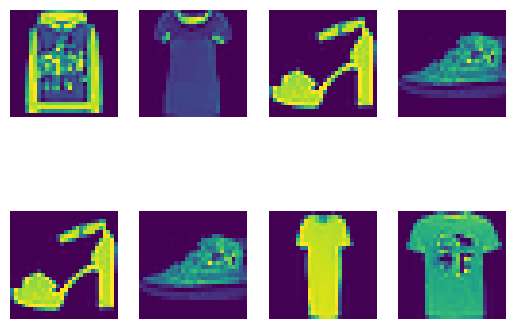

In [3]:
def displayImages(imageList, rows, columns):
    fig, grid = plt.subplots(rows,columns) 
    for i in range(rows):
        for j in range(columns):
            grid[i,j].axis('off')
            grid[i,j].imshow(np.reshape(imageList[(i-1)*rows+j], (28,28)))

numSamples = 8
randomIndices = random.sample(range(0, len(xTrain)), numSamples)
displayImages(list(np.array(xTrain)[randomIndices]), 2, 4)

<h2>Dataset Preprocessing

In [4]:
length, breadth = xTrain[0].shape
flattenDim = length * breadth
#xTrain = torch.FloatTensor(np.round(xTrain / 27).astype(int)).to(device)
xTrain = np.round(xTrain / 27).astype(int)
xTest = np.round(xTest / 27).astype(int)
xTrainFlat = torch.FloatTensor(np.reshape(xTrain, (-1,flattenDim))).to(device)
xTestFlat = np.reshape(xTest, (-1,flattenDim)) 

<h2>Initializing TrainLoader and TestLoader functions

In [5]:
trainLoader = DataLoader(dataset = xTrainFlat, batch_size = 32, shuffle = True)
testLoader = DataLoader(dataset = xTestFlat, batch_size = 16, shuffle = True)

<h2>Defining Variational AutoEncoder class

In [6]:
latentSize = 20

class variationalAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 40)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 784)
        )
    def reparameterization(self, mean, logVariance):
        standardDeviation = torch.exp(0.5 * logVariance)
        epsilonValue = torch.randn_like(standardDeviation)
        chosenSample = mean + (epsilonValue * standardDeviation)
        return chosenSample

    def forward(self, x):
        encoded = self.encoder(x)
        mean, logVariance = torch.split(encoded, 20, dim = 2)
        z = self.reparameterization(mean, logVariance)
        reconstructed = self.decoder(z)
        return mean, logVariance, reconstructed

<h2>Defining the ELBO loss function

In [7]:
def lossFunction(L2loss, Mean, logVariance):
    MSELoss = L2loss
    klDivergence = torch.mean(-0.5*torch.sum(1 + logVariance - Mean.pow(2) - logVariance.exp(),dim=1))
    totalLoss = MSELoss + klDivergence
    return totalLoss

<h2>Training the AutoEncoder model

In [8]:
vaeModel = variationalAE().to(device)
modelParameters = list(vaeModel.parameters())
criterion = nn.MSELoss()
optimizer = optim.SGD(modelParameters, lr = (1e-3), momentum = 0.7)

epochLoss = []
epochList = np.arange(0, 100, dtype = int)

encoderOutputs = []
decoderOutputs = []
for epoch in range(100):
  losses = []
  for batchIndex, batchImage in enumerate(trainLoader):
    batchImage = batchImage.to(device)
    batchImage = batchImage.unsqueeze(1)
    obtainedMean, obtainedLogVariance, reconstructedImage  = vaeModel(batchImage)
    reconstructionLoss = criterion(reconstructedImage, batchImage)
    loss = lossFunction(reconstructionLoss, obtainedMean, obtainedLogVariance)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.cpu().detach().numpy())
  print("Reconstruction Loss: ", reconstructionLoss)
  print("Epoch: ",epoch,"| Average loss: ",np.round(np.average(losses), 3),"| Lowest Loss: ",np.round(np.amin(losses), 3))
  epochLoss.append(np.round(np.amin(losses), 3))
  torch.save(vaeModel.state_dict(), "vae.pth")

Reconstruction Loss:  tensor(6.0501, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  0 | Average loss:  8.637 | Lowest Loss:  5.153
Reconstruction Loss:  tensor(4.6614, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  1 | Average loss:  6.194 | Lowest Loss:  4.445
Reconstruction Loss:  tensor(4.2954, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  2 | Average loss:  5.095 | Lowest Loss:  3.895
Reconstruction Loss:  tensor(4.3838, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  3 | Average loss:  4.706 | Lowest Loss:  3.441
Reconstruction Loss:  tensor(3.7534, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  4 | Average loss:  4.515 | Lowest Loss:  3.439
Reconstruction Loss:  tensor(3.8531, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  5 | Average loss:  4.411 | Lowest Loss:  3.348
Reconstruction Loss:  tensor(3.7033, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch:  6 | Average loss:  4.294 | Lowest Loss:  2.958
Reconstruction Loss:  tensor(3.5888, devi

<h2>Plotting graph of loss versus epochs

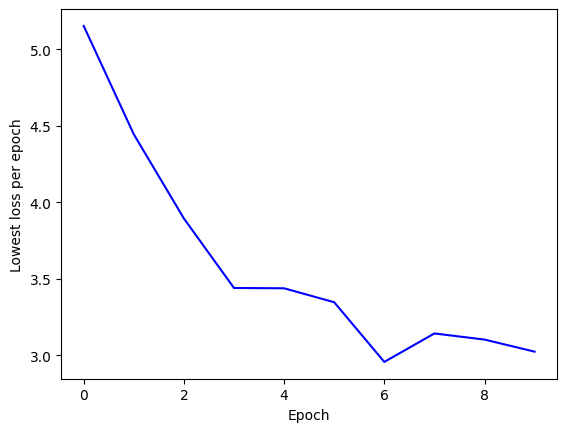

In [9]:
plt.plot(epochList, epochLoss, color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Lowest loss per epoch')
plt.show()

<h2>Evaluating reconstruction capabilities on Test Set

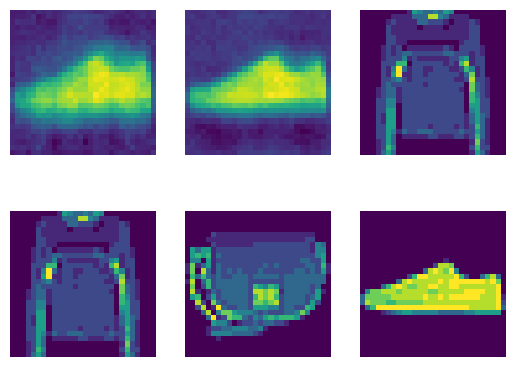

In [10]:
numSamples = 3
randomIndices = random.sample(range(0, len(xTest)), numSamples)
testSamples = list(np.array(xTestFlat)[randomIndices])
latentOutputs = []
reconstructedOutputs = []
displayList = []

vaeModel.eval()
for testImage in testSamples:
    Mean, Variance, decodedOutput = vaeModel(torch.FloatTensor(np.reshape(testImage, (-1,flattenDim))).unsqueeze(0).to(device))
    reconstructedOutputs.append(decodedOutput.cpu().detach().numpy().reshape(28, 28))
displayList = testSamples + reconstructedOutputs
displayImages(displayList, 2, 3)